ECE 4424 Machine Learning Final Project

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from math import exp
import random
random.seed(1)
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras.metrics import * 

Data Reading-in

In [2]:
#Append the directory to your python path using sys
import sys
import os

prefix = '/content/drive/My Drive/'
# modify "customized_path_to_your_homework" here to where you uploaded your homework
customized_path_to_your_homework = 'Colab Notebooks/'
sys_path = prefix + customized_path_to_your_homework
sys.path.append(sys_path)
print(sys.path)

teams_csv = os.path.join(sys_path, 'Teams.csv')
results_csv = os.path.join(sys_path, 'RegularSeasonDetailedResults.csv')
tourney_csv = os.path.join(sys_path, 'NCAATourneyCompactResults.csv')
# fp_valid = os.path.join(sys_path, 'valid_data.pkl')
print('Path to Teams.csv: {}'.format(teams_csv))
print('Path to RegularSeasonDetailedResults.csv: {}'.format(results_csv))
print('Path to NCAATourneyCompactResults.csv: {}'.format(tourney_csv))
# print('Path to valid_data.pkl: {}'.format(fp_valid))

# Mount drive
from google.colab import drive
drive.mount('/content/drive')

import csv
def load_csv(filename):
    lines = []
    with open(filename) as csvfile:
        reader = csv.DictReader(csvfile)
        for line in reader:
            lines.append(line)
    return lines

['', '/content', '/env/python', '/usr/lib/python37.zip', '/usr/lib/python3.7', '/usr/lib/python3.7/lib-dynload', '/usr/local/lib/python3.7/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.7/dist-packages/IPython/extensions', '/root/.ipython', '/content/drive/My Drive/Colab Notebooks/']
Path to Teams.csv: /content/drive/My Drive/Colab Notebooks/Teams.csv
Path to RegularSeasonDetailedResults.csv: /content/drive/My Drive/Colab Notebooks/RegularSeasonDetailedResults.csv
Path to NCAATourneyCompactResults.csv: /content/drive/My Drive/Colab Notebooks/NCAATourneyCompactResults.csv
Mounted at /content/drive


Data processing: given thousands of NCAA basketball games in one year, the code below creates averages for each team for that given year

In [3]:
teams_info = load_csv(teams_csv)
results_info = load_csv(results_csv)
tourney_info = load_csv(tourney_csv)
# print(teams_info)
# print(results_info[0])

teams = []
teamIDs = []

# Here are a couple of teamIDs to team names for references to see how teams do
# Villanova: 1437
# Virginia: 1438
# Virginia Tech: 1439

for i in range(len(teams_info)):
  teams.append(teams_info[i]['TeamName'])
  teamIDs.append(teams_info[i]['TeamID'])

stats = OrderedDict().fromkeys(teamIDs)

keys = {'GP','PS', 'OPS', 'FGM', 'OFGM', 'FGA', 'OFGA', 'FGM3', 'OFGM3', 'FGA3', 'OFGA3', 'FTM', 'OFTM', 'FTA', 'OFTA', 'FR', 'OFR', 'DR', 'ODR', 'AST', 'OAST', 'TO', 'OTO', 'STL', 'OSTL', 'BLK', 'OBLK', 'PF', 'OPF', 'GW', 'GL'}
for i in range(len(teams_info)):
  teamAverages = OrderedDict().fromkeys(keys, 0)
  stats[teams_info[i]['TeamID']] = teamAverages

print(stats)
numGames = 0

trainingYear = '2018' # Can edit for different years

for i in range(len(results_info)):
  if results_info[i]['Season'] == trainingYear: 
    numGames += 1
    winTeam = results_info[i]['WTeamID']
    loseTeam = results_info[i]['LTeamID']
    stats[winTeam]['GP'] += 1
    stats[loseTeam]['GP'] += 1
    stats[winTeam]['GW'] += 1
    stats[loseTeam]['GL'] += 1

    # The following lines of code are all adding corresponding values from the
    # given csv file into the correct team's dictionary so that averages can
    # be calculated. Since there were small discrepencies in stats that I 
    # wanted to keep as features, the code below assigns all of the win and 
    # loss data into team average and opposing team average

    stats[winTeam]['PS'] += int(results_info[i]['WScore'])
    stats[loseTeam]['PS'] += int(results_info[i]['LScore'])
    stats[winTeam]['OPS'] += int(results_info[i]['LScore'])
    stats[loseTeam]['OPS'] += int(results_info[i]['WScore'])
    stats[winTeam]['FGM'] += int(results_info[i]['WFGM'])
    stats[loseTeam]['FGM'] += int(results_info[i]['LFGM'])
    stats[winTeam]['OFGM'] += int(results_info[i]['LFGM'])
    stats[loseTeam]['OFGM'] += int(results_info[i]['WFGM'])
    stats[winTeam]['FGA'] += int(results_info[i]['WFGA'])
    stats[loseTeam]['FGA'] += int(results_info[i]['LFGA'])
    stats[winTeam]['OFGA'] += int(results_info[i]['LFGA'])
    stats[loseTeam]['OFGA'] += int(results_info[i]['WFGA'])
    stats[winTeam]['FGM3'] += int(results_info[i]['WFGM3'])
    stats[loseTeam]['FGM3'] += int(results_info[i]['LFGM3'])
    stats[winTeam]['OFGM3'] += int(results_info[i]['LFGM3'])
    stats[loseTeam]['OFGM3'] += int(results_info[i]['WFGM3'])
    stats[winTeam]['FGA3'] += int(results_info[i]['WFGA3'])
    stats[loseTeam]['FGA3'] += int(results_info[i]['LFGA3'])
    stats[winTeam]['OFGA3'] += int(results_info[i]['LFGA3'])
    stats[loseTeam]['OFGA3'] += int(results_info[i]['WFGA3'])
    stats[winTeam]['FTM'] += int(results_info[i]['WFTM'])
    stats[loseTeam]['FTM'] += int(results_info[i]['LFTM'])
    stats[winTeam]['OFTM'] += int(results_info[i]['LFTM'])
    stats[loseTeam]['OFTM'] += int(results_info[i]['WFTM'])
    stats[winTeam]['FTA'] += int(results_info[i]['WFTA'])
    stats[loseTeam]['FTA'] += int(results_info[i]['LFTA'])
    stats[winTeam]['OFTA'] += int(results_info[i]['LFTA'])
    stats[loseTeam]['OFTA'] += int(results_info[i]['WFTA'])
    stats[winTeam]['FR'] += int(results_info[i]['WOR'])
    stats[loseTeam]['FR'] += int(results_info[i]['LOR'])
    stats[winTeam]['OFR'] += int(results_info[i]['LOR'])
    stats[loseTeam]['OFR'] += int(results_info[i]['WOR'])
    stats[winTeam]['DR'] += int(results_info[i]['WDR'])
    stats[loseTeam]['DR'] += int(results_info[i]['LDR'])
    stats[winTeam]['ODR'] += int(results_info[i]['LDR'])
    stats[loseTeam]['ODR'] += int(results_info[i]['WDR'])
    stats[winTeam]['AST'] += int(results_info[i]['WAst'])
    stats[loseTeam]['AST'] += int(results_info[i]['LAst'])
    stats[winTeam]['OAST'] += int(results_info[i]['LAst'])
    stats[loseTeam]['OAST'] += int(results_info[i]['WAst'])
    stats[winTeam]['TO'] += int(results_info[i]['WTO'])
    stats[loseTeam]['TO'] += int(results_info[i]['LTO'])
    stats[winTeam]['OTO'] += int(results_info[i]['LTO'])
    stats[loseTeam]['OTO'] += int(results_info[i]['WTO'])
    stats[winTeam]['STL'] += int(results_info[i]['WStl'])
    stats[loseTeam]['STL'] += int(results_info[i]['LStl'])
    stats[winTeam]['OSTL'] += int(results_info[i]['LStl'])
    stats[loseTeam]['OSTL'] += int(results_info[i]['WStl'])
    stats[winTeam]['BLK'] += int(results_info[i]['WBlk'])
    stats[loseTeam]['BLK'] += int(results_info[i]['LBlk'])
    stats[winTeam]['OBLK'] += int(results_info[i]['LBlk'])
    stats[loseTeam]['OBLK'] += int(results_info[i]['WBlk'])
    stats[winTeam]['PF'] += int(results_info[i]['WPF'])
    stats[loseTeam]['PF'] += int(results_info[i]['LPF'])
    stats[winTeam]['OPF'] += int(results_info[i]['LPF'])
    stats[loseTeam]['OPF'] += int(results_info[i]['WPF'])

# Divide all of the accumulated stats by the amount of games that each team 
# played so that stats contains all of the information about each team's 
# averages for that given year

for team in stats:
  gamesPlayed = stats[team]['GP']
  if gamesPlayed != 0:
    for key in stats[team].keys():
      if key != 'GP' and key != 'GW' and key != 'GL':
        stats[team][key] /= gamesPlayed

print(stats['1437']) # Sample Villanova in the year 2018 when they won
print(numGames) # number of Games in 2018

OrderedDict([('1101', OrderedDict([('OFTA', 0), ('AST', 0), ('GP', 0), ('FGM', 0), ('FTA', 0), ('OAST', 0), ('PS', 0), ('PF', 0), ('FGM3', 0), ('OBLK', 0), ('OTO', 0), ('OFGM3', 0), ('OSTL', 0), ('ODR', 0), ('DR', 0), ('FGA', 0), ('FGA3', 0), ('BLK', 0), ('OFTM', 0), ('OFGA3', 0), ('OFGA', 0), ('TO', 0), ('FR', 0), ('FTM', 0), ('STL', 0), ('OPF', 0), ('OFGM', 0), ('OPS', 0), ('GL', 0), ('GW', 0), ('OFR', 0)])), ('1102', OrderedDict([('OFTA', 0), ('AST', 0), ('GP', 0), ('FGM', 0), ('FTA', 0), ('OAST', 0), ('PS', 0), ('PF', 0), ('FGM3', 0), ('OBLK', 0), ('OTO', 0), ('OFGM3', 0), ('OSTL', 0), ('ODR', 0), ('DR', 0), ('FGA', 0), ('FGA3', 0), ('BLK', 0), ('OFTM', 0), ('OFGA3', 0), ('OFGA', 0), ('TO', 0), ('FR', 0), ('FTM', 0), ('STL', 0), ('OPF', 0), ('OFGM', 0), ('OPS', 0), ('GL', 0), ('GW', 0), ('OFR', 0)])), ('1103', OrderedDict([('OFTA', 0), ('AST', 0), ('GP', 0), ('FGM', 0), ('FTA', 0), ('OAST', 0), ('PS', 0), ('PF', 0), ('FGM3', 0), ('OBLK', 0), ('OTO', 0), ('OFGM3', 0), ('OSTL', 0), (

Functions developed earlier in the year & editted specifically for this project



In [5]:
# Logistic Regression via Stochastic Gradient-Based Optimization

def dot(x, y):
    s = None # dot product over x and y
    s = 0
    for i in range(len(x)):
      s = s + (x[i]*y[i])
    return s

def logistic(x):
    s = None# logistic function over x
    den = 1 + exp(-1*x)
    s = 1 / den
    return s

def predict(model, point):
    p = None # prediction value returned from logistic function
    d = dot(model, point.get('features'))
    p = logistic(d)
    return p

def accuracy(data, predictions):
    # TODO: Calculate accuracy of predictions on data
    correct = None# number of correctedly predicted data points
    correct = 0
    for i in range(len(predictions)):
      if (predictions[i] >= 0.5) == data[i]['label']:
        correct = correct + 1
    return float(correct)/len(data)

def extract_features(raw):
    data = [] 
    for game in raw:
      if game['Season'] == trainingYear:
        team1 = game['WTeamID']
        team0 = game['LTeamID']
        point = {}
        weights = []
        wl = random.uniform(0,1)
        #print("Random numberr", wl)
        if wl > 0.5:
          for key in stats[team1].keys():
            weights.append(stats[team1][key]/100)
          for key in stats[team0].keys():
            weights.append(stats[team0][key]/100)
          point['label'] = True
          point['features'] = weights
        else:
          for key in stats[team0].keys():
            weights.append(stats[team0][key]/100)
          for key in stats[team1].keys():
            weights.append(stats[team1][key]/100)
          point['label'] = False
          point['features'] = weights
        #print("Length of features", len(weights))
        data.append(point)
    return data

def weigh_specific_features(raw):
    data = [] 
    for game in raw:
      if game['Season'] == trainingYear:
        team1 = game['WTeamID']
        team0 = game['LTeamID']
        point = {}
        weights = []
        wl = random.uniform(0,1)
        #print("Random numberr", wl)
        if wl > 0.5:
          for key in stats[team1].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team1][key]/100)
            else:
              weights.append(stats[team1][key]/200)
          for key in stats[team0].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team0][key]/100)
            else:
              weights.append(stats[team0][key]/200)
          point['label'] = True
          point['features'] = weights
        else:
          for key in stats[team0].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team0][key]/100)
            else:
              weights.append(stats[team0][key]/200)
          for key in stats[team1].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team1][key]/100)
            else:
              weights.append(stats[team1][key]/200)
          point['label'] = False
          point['features'] = weights
        #print("Length of features", len(weights))
        data.append(point)
    return data

def extract_some_features(raw):
    data = [] 
    for game in raw:
      if game['Season'] == trainingYear:
        team1 = game['WTeamID']
        team0 = game['LTeamID']
        point = {}
        weights = []
        wl = random.uniform(0,1)
        #print("Random numberr", wl)
        if wl > 0.5:
          for key in stats[team1].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team1][key]/100)
          for key in stats[team0].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team0][key]/100)
          point['label'] = True
          point['features'] = weights
        else:
          for key in stats[team0].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team0][key]/100)
          for key in stats[team1].keys():
            if key == 'FGM' or key == 'FGA' or key == 'OFGM' or key == 'OFGA' or key == 'PS' or key == 'OPS' or key == 'STL' or key == 'OSTL' or key == 'BLK' or key == 'OBLK' or key == 'GW' or key == 'GL': 
              weights.append(stats[team1][key]/100)
          point['label'] = False
          point['features'] = weights
        #print("Length of features", len(weights))
        data.append(point)
    return data

def extract_datalabel(raw):
    for game in raw:
      if game['Season'] == trainingYear:
        team1 = game['WTeamID']
        team0 = game['LTeamID']
        labels = []
        weights = []
        wl = random.uniform(0,1)
        #print("Random numberr", wl)
        if wl > 0.5:
          for key in stats[team1].keys():
            weights.append(stats[team1][key]/100)
          for key in stats[team0].keys():
            weights.append(stats[team0][key]/100)
          labels.append(1)
        else:
          for key in stats[team0].keys():
            weights.append(stats[team0][key]/100)
          for key in stats[team1].keys():
            weights.append(stats[team1][key]/100)
          labels.append(0)
        #print("Length of features", len(weights))
    return weights, labels

# TODO: Initialize model
def initialize_model(k):
    return [random.gauss(0, 2) for x in range(k)] #modified range for tuning

# TODO: Train model using training data

def train(data, epochs, rate, lam):
    model = initialize_model(len(data[0]['features']))
    num_features = len(data[0]['features']);
    mo = []
    for i in range(epochs):
      # print("Epoch: ", i)
      for j in range(num_features):
        for k in range(len(data)):
          item = random.choice(data)
          p = predict(model, item)
          actual = item['label']        
          difference = actual - p
          model[j] = model[j] - rate*lam*model[j] + rate*(item['features'][j]*difference) # equation from above
      mo.append(model.copy())
    print(mo)
    return model, mo

def runModel(data):
    random.seed(1)
    return train(data, 60, 1e-2, 1e-5) # fine tuned parameters

def plotModel(epochs, acc, accv, title):
  plt.figure(figsize=(8, 6))
  lst = list(np.arange(1,epochs+1))
  plt.plot(lst, acc, '-o', label = 'Regular Season')
  plt.plot(lst, accv, '-o', label = 'Tournament')
  plt.legend(loc= "lower right")
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.title(title)
  




Testing & Validation Accuracy Printing

[[-0.8882258570176519, 1.1267475251076544, -2.212813496804243, -2.163669828640146, -2.3989334915024045, -0.1437542818864911, -1.9499037009494595, -3.1431081008352497, 0.30921301389273387, 0.21059935296609467, 1.0430263149136978, -1.889244146865163, -0.06829794147192905, -0.352821291379168, -3.0101588900106218, 1.0960227432777914, 0.6908241054982318, 4.787552065152142, 0.3099741720300069, -0.32281389260022725, 2.3861809305768205, 0.3829393054354123, 1.867193786935721, -0.542897656893576, 0.45919868406129194, 2.0939962180860596, 1.3194969755900416, 0.25049354484050707, -2.4173079985103407, 1.5052397922312342, 0.07354329406331661, 1.506395550976297, 0.297093707699443, 2.1261943065701137, -0.13530420965932063, 0.3508704540834049, 1.4699422194668552, -2.1518160847501475, -0.8203092267930986, -1.085274892493816, 3.9691609296730026, -0.19564617411867413, 1.2860104915395492, 1.2455447001135511, -0.5961206667705852, -3.104931584589194, 1.9568563424940664, -0.8235611788143853, 1.374477260637052,

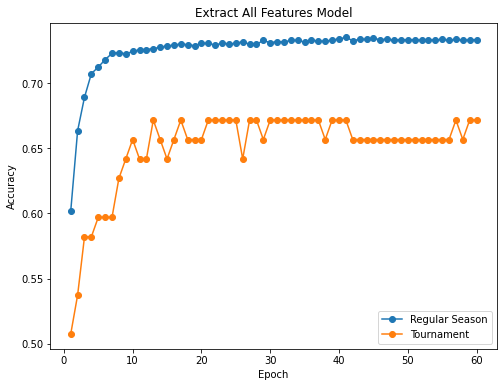

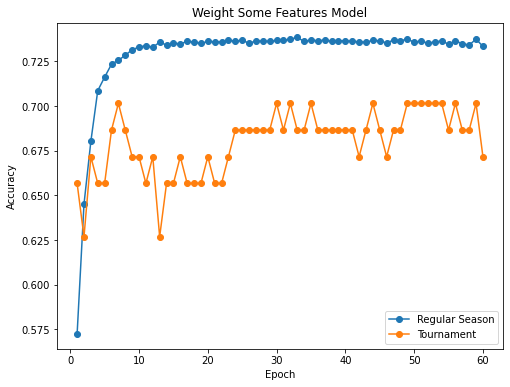

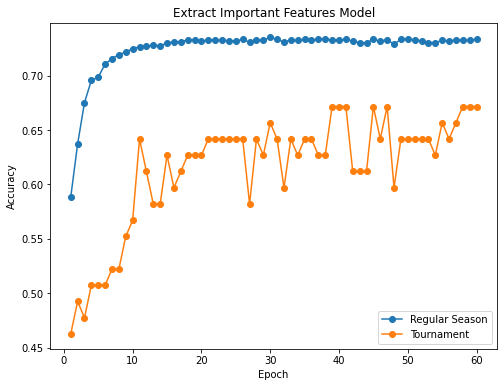

In [6]:
ft = extract_features(results_info)
vt = extract_features(tourney_info)

epochs = 60

model, listModels = runModel(ft)
acc = []
accv = []
for m in listModels:
  prediction = [predict(m, p) for p in ft]
  acc.append(accuracy(ft, prediction))
  prediction = [predict(m, p) for p in vt]
  accv.append(accuracy(vt, prediction))

plotModel(epochs, acc, accv, "Extract All Features Model")

predictions = [predict(model, p) for p in ft]
print("Training Accuracy:", accuracy(ft, predictions))
predictions = [predict(model, p) for p in vt]
print("Validation Accuracy:", accuracy(vt, predictions))

ft = weigh_specific_features(results_info)
vt = weigh_specific_features(tourney_info)

model, listModels = runModel(ft)
acc = []
accv = []
for m in listModels:
  prediction = [predict(m, p) for p in ft]
  acc.append(accuracy(ft, prediction))
  prediction = [predict(m, p) for p in vt]
  accv.append(accuracy(vt, prediction))

plotModel(epochs, acc, accv, "Weight Some Features Model")
predictions = [predict(model, p) for p in ft]
print("Training Accuracy:", accuracy(ft, predictions))
predictions = [predict(model, p) for p in vt]
print("Validation Accuracy:", accuracy(vt, predictions))

ft = extract_some_features(results_info)
vt = extract_some_features(tourney_info)

model, listModels = runModel(ft)
acc = []
accv = []
for m in listModels:
  prediction = [predict(m, p) for p in ft]
  acc.append(accuracy(ft, prediction))
  prediction = [predict(m, p) for p in vt]
  accv.append(accuracy(vt, prediction))

plotModel(epochs, acc, accv, "Extract Important Features Model")

predictions = [predict(model, p) for p in ft]
print("Training Accuracy:", accuracy(ft, predictions))
predictions = [predict(model, p) for p in vt]
print("Validation Accuracy:", accuracy(vt, predictions))

Potential CNN Model to edit in a future project, not fully functional, experimental purposes

In [ ]:
trainData, trainLabel = extract_datalabel(results_info)

trainData = trainData.to_numpy() # few issues with data conversion
trainLabel = trainLabel.to_numpy()

model1 = Sequential()
model1.add(Dense(16, activation='relu', input_shape=(8,)))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))
metrics = [AUC(), FalsePositives(),FalseNegatives(),TruePositives(),TrueNegatives(),'sparse_categorical_accuracy', 'accuracy']

def runModel(model=model1,mess=False, epochs=50, metrics = metrics, batchSize=32, weights={0:1,1:1}):
  model.compile(optimizer='adam', loss='binary_crossentropy',metrics=metrics)
  model.fit(trainData, trainLabel, epochs=epochs, batch_size=batchSize, validation_split=0.2,verbose=bool(mess),class_weight=weights) 

  evals = model.evaluate(trainData, trainLabel, verbose=int(mess))
  evals = list(map(lambda x: round(x, 5), evals))
  labels = ['loss'] +  [x.name if type(x)!=str else x for x in metrics]
  print(labels)
  evals = list(zip(labels,evals))
  print(evals)

  return (model,evals)

model1 = runModel(model = model1, epochs = 25, batchSize = 32, mess = 1, metrics = metrics)